In [ ]:
#Eureka_Powers
#Compares the return powers from the air-snow and snow-ice interfaces to each other
#Shows the distributions of powers infer a diffuse component and a specular component of reflection
#Claude de Rijke-Thomas
#16th May 2022

In [1]:
icetype = 'myi' #the ice type that we want to be investigating (can either be fyi or myi)
saving = False
from LPS_functions import *

In [2]:
#initialising empty arrays:
lat = np.array([], dtype='double')
lon = np.array([], dtype='double')
b_as = np.array([],dtype='int')
b_si = np.array([], dtype='int')
snow_depth_dot_n = np.array([], dtype='double')

insitu_data_filepath = '/Users/claudederijkethomas/Desktop/PhD/PYTHON/OIB/'\
                        +'19-21Apr2016/SR/insitu_data_eureka.csv'

#opening the csv file to read through (to make a loading bar of progress):
line_count=0
with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    for line in readCSV:
        line_count+=1        
#Timestamp,Counter,DepthCm,Latitude,Longitude,Site,IceType are the headers
Timestamp = np.array([], dtype='str')
Counter = np.array([], dtype='int')
DepthCm = np.array([], dtype='double')
Latitude = np.array([], dtype='double')
Longitude = np.array([], dtype='double')
Site = np.array([], dtype='str')
IceType = np.array([], dtype='str')

with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    count=-1
    for line in readCSV:
        count+=1
        if count%1000==0:
            sys.stdout.write("\r"+str(100*count/line_count)+"% of the way ")
        if str(line['Timestamp'][0:2]).isdigit():
            if int(line['Timestamp'][0:2])>=15: # if data is taken on the 15th or later
                if str(line['IceType'])==icetype:
                    Timestamp = np.append(Timestamp, str(line['Timestamp']))
                    Counter = np.append(Counter, int(line['Counter']))
                    DepthCm = np.append(DepthCm, float(line['DepthCm']))
                    Latitude = np.append(Latitude, float(line['Latitude']))
                    Longitude = np.append(Longitude, float(line['Longitude']))
                    Site = np.append(Site, str(line['Site']))
                    IceType = np.append(IceType, str(line['IceType']))

    sys.stdout.write("\r"+"100% complete                 ")

100% complete                  

In [3]:
insitu_xs, insitu_ys = easeProj(Longitude,Latitude)
insitu_kdtree = spatial.cKDTree(np.column_stack((insitu_xs, insitu_ys)))


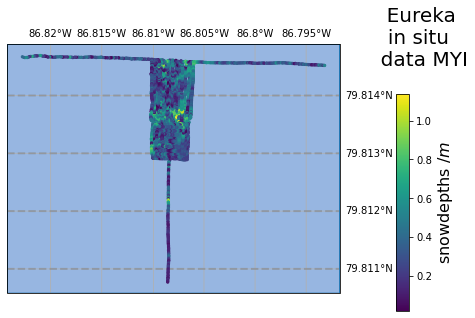

In [4]:
fig = plt.figure()

central_lon,central_lat = np.mean(Longitude),np.mean(Latitude)
ax = fig.add_axes([0,0,0.77,1], projection=ccrs.Orthographic(central_lon,central_lat))
scat = ax.scatter(Longitude,Latitude,s=5,c=DepthCm,transform=ccrs.PlateCarree(), zorder=3)
ax.gridlines()
cbar_ax = fig.add_axes([0.90, 0.007, 0.03, 0.753]) #start xpos, start ypos, #xwidth, ylendth
cbar_ax.set_title("       Eureka \n     in situ\n       data "+str(icetype).upper()+"\n",fontsize=20)
lol = cbar_ax.scatter(x=np.zeros(len(DepthCm)),y=np.zeros(len(DepthCm)),c=DepthCm/100)
cb = fig.colorbar(lol, cax=cbar_ax)
cb.set_label('snowdepths $/m$', size=16)

ax.coastlines(resolution='50m')
ocean110 = cartopy.feature.NaturalEarthFeature('physical', 'ocean', \
    scale='50m', edgecolor='none', facecolor=cartopy.feature.COLORS['water'])
ax.add_feature(ocean110)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = True
gl.left_labels = False
gl.xlines = False

xlims = ax.get_xlim()
ylims = ax.get_ylim()

extent_lonlat = ax.get_extent(crs=ccrs.PlateCarree())

dataExtentPolygon = Polygon([(extent_lonlat[0],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[3]),\
                             (extent_lonlat[0],extent_lonlat[3])])
ax.plot(*dataExtentPolygon.exterior.xy,transform=ccrs.PlateCarree())

ax.set_extent(extent_lonlat,crs=ccrs.PlateCarree())
plt.show()

In [5]:
if icetype=='fyi':
    coincident_ku_files = ['IRKUB1B_20160419_04_004_deconv.nc', 'IRKUB1B_20160419_04_032_deconv.nc', 'IRKUB1B_20160419_04_050_deconv.nc', 'IRKUB1B_20160419_04_080_deconv.nc', 'IRKUB1B_20160419_04_180_deconv.nc', 'IRKUB1B_20160419_04_208_deconv.nc', 'IRKUB1B_20160419_04_230_deconv.nc', 'IRKUB1B_20160419_04_258_deconv.nc', 'IRKUB1B_20160419_04_259_deconv.nc']
elif icetype=='myi':
    coincident_ku_files = ['IRKUB1B_20160419_04_035_deconv.nc', 'IRKUB1B_20160419_04_047_deconv.nc', 'IRKUB1B_20160419_04_083_deconv.nc', 'IRKUB1B_20160419_04_176_deconv.nc', 'IRKUB1B_20160419_04_211_deconv.nc', 'IRKUB1B_20160419_04_226_deconv.nc', 'IRKUB1B_20160419_04_262_deconv.nc']

In [6]:
"""Making an overlapping KDTree of all the atm data from all of the flyovers"""
all_overlapping_h5_files = []
for ku_file in coincident_ku_files:
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                all_overlapping_h5_files.append(coinc[0])
                ku_files = coinc[1]
                
all_overlapping_h5_files = list(dict.fromkeys(all_overlapping_h5_files))
atm_laser = projectedLaser(all_overlapping_h5_files, "ease")
x_atm_laser,y_atm_laser = atm_laser.east, atm_laser.north

overlapping_kdtree = spatial.cKDTree(np.column_stack((x_atm_laser, y_atm_laser)))

In [7]:
"""using the ATM laser file offsets to align each ATM laser file to each other (each ATM file has an altimetric offset relative to the others
 determined by its mean patch offset, relative to the overall mean patch elevation of the ATM laser files combined).
 These offsets are calculated in Eureka_ATM_laser_Offsets.ipynb"""
if icetype == 'fyi':
    #this is  mean_atm_elev_each_flyover - np.mean(mean_atm_elev_each_flyover)
    atm_elev_flyover_offsets = [-0.00142218, -0.00882589, -0.0182781, -0.01468046, -0.06314833, 0.0375774, 0.02246962, 0.02315396, 0.02315396] #for first year ice!!!!
elif icetype == 'myi':
    atm_elev_flyover_offsets = [-0.01541401, -0.02724434, -0.00367711, -0.05813091, 0.03078281, 0.03742214, 0.03626142]
all_overlapping_atm_alts_arr = np.array([],dtype='double')
for i,ku_file in enumerate(coincident_ku_files):
    h5_files = []
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                h5_files.append(coinc[0])
                ku_files = coinc[1]
    atm = projectedLaser(h5_files, "ease")
    all_overlapping_atm_alts_arr = np.append(all_overlapping_atm_alts_arr, atm.alt - atm_elev_flyover_offsets[i])
    
#overriding the atm altitudes to compensate for the offsets between the atm files:
atm_laser.alt = all_overlapping_atm_alts_arr

In [8]:
offset_list_2D = []
angle_thresh=3

for ku_file_counter, ku_file in enumerate(coincident_ku_files):
    offset_list_file = []
    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    j=-1
    for footprint, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            unlog_amp = 10**(np.array(log_amplitude[j])/10)
            try:
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
            except:
                print(Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                raise

    offset_list_2D.append(offset_list_file)

[ 0.07708323  0.07671809  0.039888    0.00644744 -0.02853764 -0.00534176
 -0.0180985 ]
[0.07180564 0.08564682 0.10897266 0.11788031 0.08795264 0.09404222
 0.09688887]
[508. 636. 544. 520. 509. 492. 518.]


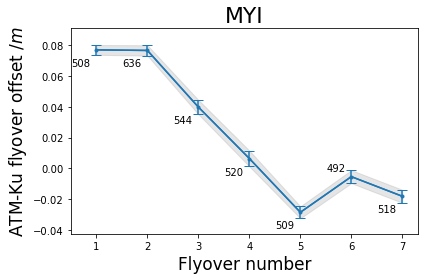

In [9]:
atm_ku_flyover_offset_means = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_lens = np.full(len(offset_list_2D),np.nan, dtype= 'double')
atm_ku_flyover_offset_stds = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_stes = np.full(len(offset_list_2D),np.nan, dtype='double')
for i, file_offsets in enumerate(offset_list_2D):
#     if i==1:
#         pass
#         p(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_means[i] = np.nanmean(file_offsets)
    atm_ku_flyover_offset_stds[i] = np.nanstd(file_offsets, ddof=1)
    atm_ku_flyover_offset_stes[i] = np.nanstd(file_offsets, ddof=1)/np.sqrt(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_lens[i] = len(np.array(file_offsets)[~np.isnan(file_offsets)])
#         print(np.nanmax(file_offsets))

print(atm_ku_flyover_offset_means)
print(atm_ku_flyover_offset_stds)
print(atm_ku_flyover_offset_lens)
errorPlot(range(1,len(atm_ku_flyover_offset_means)+1),atm_ku_flyover_offset_means, atm_ku_flyover_offset_stes, point_labels=atm_ku_flyover_offset_lens)
plt.xticks(range(1,len(atm_ku_flyover_offset_means)+1))
plt.ylabel("ATM-Ku flyover offset $/m$",fontsize=17)
plt.xlabel("Flyover number",fontsize=17)
plt.title(icetype.upper(), fontsize=22)
plt.tight_layout()
# plt.savefig("plots/ATMKuFlyoverOffsets.png", dpi=200)

#uncomment this line if you want a global offset instead of a file-by-file offset:
# atm_ku_flyover_offset_means[:] = np.nanmean(fflat(offset_list_2D))

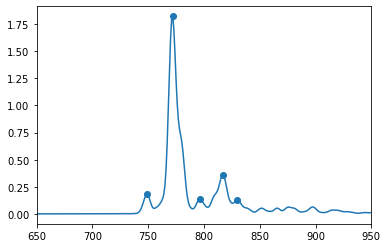

6.000783145252341
5.574206222175418
[7.39877101 7.38579523 7.37281945 7.35984367 7.34686789 7.3338921
 7.32091632 7.30794054 7.29496476 7.28198898 7.2690132  7.25603741
 7.24306163 7.23008585 7.21711007 7.20413429 7.19115851 7.17818273
 7.16520694 7.15223116 7.13925538 7.1262796  7.11330382 7.10032804
 7.08735225 7.07437647 7.06140069 7.04842491 7.03544913 7.02247335
 7.00949756 6.99652178 6.983546   6.97057022 6.95759444 6.94461866
 6.93164287 6.91866709 6.90569131 6.89271553 6.87973975 6.86676397
 6.85378819 6.8408124  6.82783662 6.81486084 6.80188506 6.78890928
 6.7759335  6.76295771 6.74998193 6.73700615 6.72403037 6.71105459
 6.69807881 6.68510302 6.67212724 6.65915146 6.64617568 6.6331999
 6.62022412 6.60724833 6.59427255 6.58129677 6.56832099 6.55534521
 6.54236943 6.52939365 6.51641786 6.50344208 6.4904663  6.47749052
 6.46451474 6.45153896 6.43856317 6.42558739 6.41261161 6.39963583
 6.38666005 6.37368427 6.36070848 6.3477327  6.33475692 6.32178114
 6.30880536 6.29582958 6.282

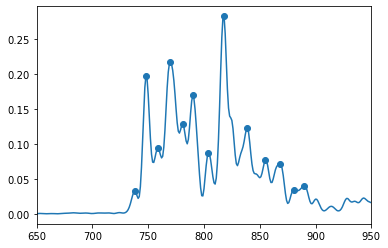

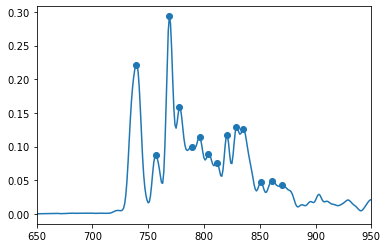

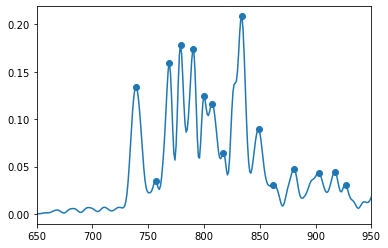

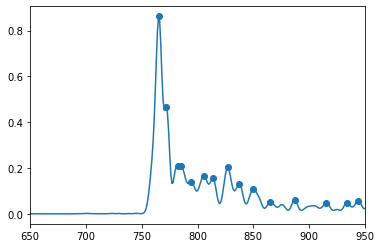

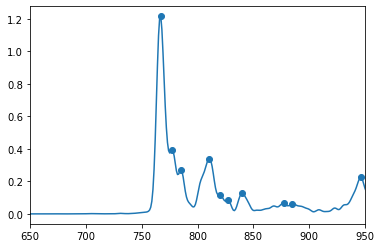

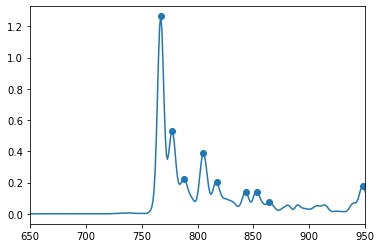

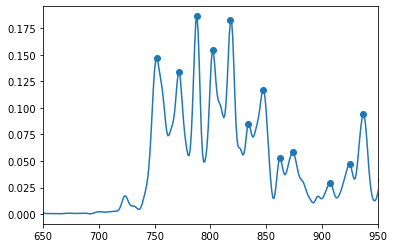

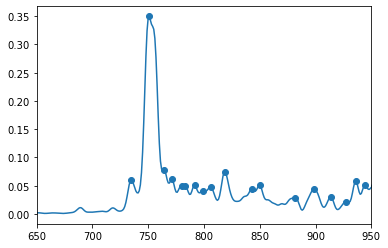

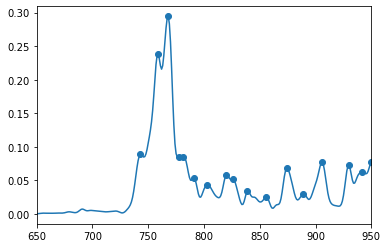

In [11]:
angle_thresh=3
lol= True
snowice_interp_unlog_amps = np.array([],dtype='double')
airsnow_interp_unlog_amps = np.array([],dtype='double')
closest_peak_amps_to_airsnow_interp_range_bin = np.array([],dtype='double')
closest_peak_amps_to_snowice_interp_range_bin = np.array([],dtype='double')
lin_regress_angles_snowice_bigger_than_airsnow = np.array([],dtype='double')
lin_regress_angles_airsnow_bigger_than_snowice = np.array([],dtype='double')
airsnow_stds_snowice_bigger_than_airsnow = np.array([],dtype='double')
airsnow_stds_airsnow_bigger_than_snowice = np.array([],dtype='double')

footprint_alts_stds = np.array([],dtype='double')
footprint_alts_stds_airsnow_bigger_than_snowice = np.array([],dtype='double')
footprint_alts_stds_snowice_bigger_than_airsnow = np.array([],dtype='double')
plot_counter = 0
for ku_file_counter, ku_file in enumerate(coincident_ku_files):

    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    # print(np.shape(fasttime_ku))
    # print(fasttime_ku[0:30])
    j=-1
    for footprint_poly, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            footprint_alts_stds = np.append(footprint_alts_stds, np.std(atm_alts_within,ddof=1))
            "remember I need to include the ATM-Ku offsets as well as I'm working with altitudes"
            indices_of_insitu_points_within_5m_of_footprint_centre = insitu_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
            indices_of_atm_points_within_10m_of_footprint_centre = overlapping_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=10)
            footprint_insitu_snowdepths = np.array([],dtype='double') 
            for i in indices_of_insitu_points_within_5m_of_footprint_centre:
                if footprint_poly.contains(Point(insitu_xs[i],insitu_ys[i])):
                    footprint_insitu_snowdepths = np.append(footprint_insitu_snowdepths,DepthCm[i]/100)
            if np.any(footprint_insitu_snowdepths):
                atm_derived_alt_of_airsnow_interface = np.mean(atm_alts_within)
                atm_insitu_derived_alt_of_snowice_interface = np.mean(atm_alts_within) - np.mean(footprint_insitu_snowdepths)
                
                #converting the altitudes of the atm-insitu derived air-snow and snow-ice interfaces into interpolated range bin numbers
                #(so that I can estimate the amplitudes of the air-snow and snow-ice interfaces)::::
                arr_of_ku_alts_from_fasttimes = aircraft_alt_ku[j] + atm_ku_flyover_offset_means[ku_file_counter] - (np.array(fasttime_ku)*10**-6/2) * 299792458
                #np.interp assumes monotonically increasing, whereas we want monotonically decreasing in altitude (corresponding to increasing range bins) 
                #so we need to do some subsequent rearranging:::
                arr_of_ku_alts_from_fasttimes_flipped = np.flip(arr_of_ku_alts_from_fasttimes)
                airsnow_interp_range_bin, snowice_interp_range_bin = np.interp([atm_derived_alt_of_airsnow_interface,atm_insitu_derived_alt_of_snowice_interface],arr_of_ku_alts_from_fasttimes_flipped, \
                                    np.arange(len(fasttime_ku)-1,-1,-1))
                unlog_amp = 10**(np.array(log_amplitude[j])/10)
                
                
                preliminary_start_of_signal  = [i for i,v in enumerate(unlog_amp) if v > np.mean(unlog_amp[:250])+6*np.std(unlog_amp[:250], ddof=1)][10]
                i = preliminary_start_of_signal
                while unlog_amp[i]>np.mean(unlog_amp[:250])+2.5*np.std(unlog_amp[:250], ddof=1):
                    i-=1
                start_of_signal=i                
                peak_indices, peak_dict = find_peaks(unlog_amp/simps(unlog_amp[start_of_signal:start_of_signal+250]), height=0.002) #finding all the indices of all the peaks in the echo
                closest_peak_index_to_airsnow_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - airsnow_interp_range_bin))]
                closest_peak_index_to_snowice_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - snowice_interp_range_bin))]
                if closest_peak_index_to_airsnow_interp_range_bin!=closest_peak_index_to_snowice_interp_range_bin:
                    closest_peak_amps_to_airsnow_interp_range_bin = np.append(closest_peak_amps_to_airsnow_interp_range_bin, unlog_amp[closest_peak_index_to_airsnow_interp_range_bin])
                    closest_peak_amps_to_snowice_interp_range_bin = np.append(closest_peak_amps_to_snowice_interp_range_bin, unlog_amp[closest_peak_index_to_snowice_interp_range_bin])

                airsnow_interp_unlog_amp, snowice_interp_unlog_amp = np.interp([airsnow_interp_range_bin, snowice_interp_range_bin], range(len(fasttime_ku)), unlog_amp)
                airsnow_interp_unlog_amps = np.append(airsnow_interp_unlog_amps, airsnow_interp_unlog_amp)
                snowice_interp_unlog_amps = np.append(snowice_interp_unlog_amps, snowice_interp_unlog_amp)
                
                if unlog_amp[closest_peak_index_to_airsnow_interp_range_bin] > unlog_amp[closest_peak_index_to_snowice_interp_range_bin]: # or can also do airsnow_interp_unlog_amp > snowice_interp_unlog_amp:
                    if plot_counter<10:
                        
                        plt.scatter(peak_indices,unlog_amp[peak_indices])
                        plt.plot(unlog_amp)
                        plt.xlim(650,950)
                        plt.show()
                        plot_counter+=1
                    footprint_alts_stds_airsnow_bigger_than_snowice = np.append(footprint_alts_stds_airsnow_bigger_than_snowice, np.std(atm_alts_within,ddof=1))
                    atm_estimated_airsnow_cross_track_projs = np.array([],dtype='double')
                    atm_estimated_airsnow_interface_alts = np.array([],dtype='double')
                    for atm_index in indices_of_atm_points_within_10m_of_footprint_centre:
                        atm_estimated_airsnow_interface_alts = np.append(atm_estimated_airsnow_interface_alts, \
                                                                                    atm_laser.alt[atm_index])
                        theta_of_atm = atan2(x_atm_laser[atm_index]-x_ku[j], y_atm_laser[atm_index]-y_ku[j])
                        atm_dist_from_centre = np.sqrt((x_atm_laser[atm_index]-x_ku[j])**2.0 + (y_atm_laser[atm_index]-y_ku[j])**2.0)
                        atm_estimated_airsnow_cross_track_projs = np.append(atm_estimated_airsnow_cross_track_projs, \
                                                                                           atm_dist_from_centre*np.sin(theta_of_atm - azi_angle[j])) 
                    across_track_linregress = linregress(atm_estimated_airsnow_cross_track_projs,atm_estimated_airsnow_interface_alts)
                    # across_track_linregresses.append(across_track_linregress)
                    lin_regress_angles_airsnow_bigger_than_snowice = np.append(lin_regress_angles_airsnow_bigger_than_snowice, atan(across_track_linregress.slope)) #in radians!!
                    airsnow_stds_airsnow_bigger_than_snowice = np.append(airsnow_stds_airsnow_bigger_than_snowice, np.std(atm_estimated_airsnow_interface_alts,ddof=1))
                    pass
                elif unlog_amp[closest_peak_index_to_snowice_interp_range_bin] > unlog_amp[closest_peak_index_to_airsnow_interp_range_bin]:
                    
                    footprint_alts_stds_snowice_bigger_than_airsnow = np.append(footprint_alts_stds_snowice_bigger_than_airsnow, np.std(atm_alts_within,ddof=1))
                    atm_estimated_airsnow_cross_track_projs = np.array([],dtype='double')
                    atm_estimated_airsnow_interface_alts = np.array([],dtype='double')
                    for atm_index in indices_of_atm_points_within_10m_of_footprint_centre:
                        atm_estimated_airsnow_interface_alts = np.append(atm_estimated_airsnow_interface_alts, \
                                                                                    atm_laser.alt[atm_index])
                        theta_of_atm = atan2(x_atm_laser[atm_index]-x_ku[j], y_atm_laser[atm_index]-y_ku[j])
                        atm_dist_from_centre = np.sqrt((x_atm_laser[atm_index]-x_ku[j])**2.0 + (y_atm_laser[atm_index]-y_ku[j])**2.0)
                        atm_estimated_airsnow_cross_track_projs = np.append(atm_estimated_airsnow_cross_track_projs, \
                                                                                           atm_dist_from_centre*np.sin(theta_of_atm - azi_angle[j])) 
                    across_track_linregress = linregress(atm_estimated_airsnow_cross_track_projs,atm_estimated_airsnow_interface_alts)
                    # across_track_linregresses.append(across_track_linregress)
                    lin_regress_angles_snowice_bigger_than_airsnow = np.append(lin_regress_angles_snowice_bigger_than_airsnow, atan(across_track_linregress.slope)) #in radians!!
                    airsnow_stds_snowice_bigger_than_airsnow = np.append(airsnow_stds_snowice_bigger_than_airsnow, np.std(atm_estimated_airsnow_interface_alts,ddof=1))
                if lol:
                    print(atm_derived_alt_of_airsnow_interface)
                    print(atm_insitu_derived_alt_of_snowice_interface)
                    print(arr_of_ku_alts_from_fasttimes[650:810])
                    print(airsnow_interp_range_bin)
                    print(snowice_interp_range_bin)
                    print(snowice_interp_unlog_amp)
                    print(airsnow_interp_unlog_amp)
                    print(len(fasttime_ku))
                    lol=False


0.5707840930729492
0.13437701595319473
168
0.6693959479616316
0.15815051527736562
139


Ttest_indResult(statistic=1.3450904767743834, pvalue=0.08979764518783137)
mean of stds where snowice peak is bigger than the airsnow:  0.15815051527736562
mean of stds where airsnow peak is bigger than the snowice:  0.13437701595319473
Ttest_indResult(statistic=2.759975382076044, pvalue=0.003065151571327184)


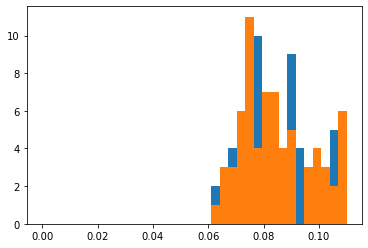

In [12]:
print(np.mean(abs(180/np.pi*lin_regress_angles_airsnow_bigger_than_snowice)))
print(np.mean(airsnow_stds_airsnow_bigger_than_snowice))
print(len(airsnow_stds_airsnow_bigger_than_snowice))
print(np.mean(abs(180/np.pi*lin_regress_angles_snowice_bigger_than_airsnow)))
print(np.mean(airsnow_stds_snowice_bigger_than_airsnow))
print(len(airsnow_stds_snowice_bigger_than_airsnow))
print("\n")
print(stats.ttest_ind(lin_regress_angles_airsnow_bigger_than_snowice, lin_regress_angles_snowice_bigger_than_airsnow, alternative='greater'))
print("mean of stds where snowice peak is bigger than the airsnow: ",np.mean(airsnow_stds_snowice_bigger_than_airsnow))
print("mean of stds where airsnow peak is bigger than the snowice: ",np.mean(airsnow_stds_airsnow_bigger_than_snowice))
#testing to see whether the stds where the snowice peak is bigger than the airsnow peak are significantly bigger (which you would expect because the airnsow peak is smudged)
print(stats.ttest_ind(airsnow_stds_snowice_bigger_than_airsnow, airsnow_stds_airsnow_bigger_than_snowice, alternative='greater')) #a,b testing if a>b
plt.hist(airsnow_stds_snowice_bigger_than_airsnow, bins = np.linspace(0,.11,37))
plt.hist(airsnow_stds_airsnow_bigger_than_snowice,bins = np.linspace(0,.11,37));

In [13]:
print(np.nanmean(footprint_alts_stds))
print(np.mean(footprint_alts_stds_airsnow_bigger_than_snowice))

0.07822842122608306
0.10440471977662646


In [14]:
print(np.mean(snowice_interp_unlog_amps))
print(np.mean(airsnow_interp_unlog_amps))

0.523031339639142
0.2727105150134811


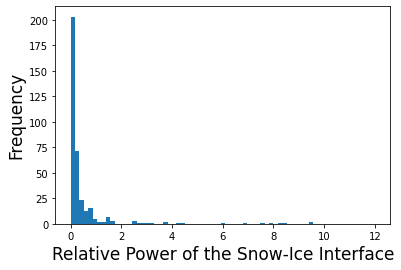

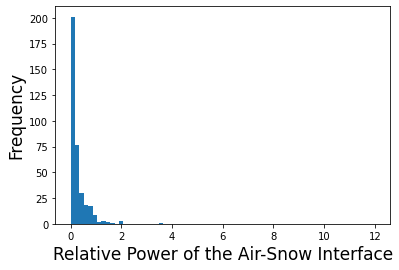

In [15]:
plt.hist(snowice_interp_unlog_amps, bins=np.linspace(0,12,70))
# plt.title("Relative Powers of the Snow-Ice Interface",fontsize=17)
plt.xlabel("Relative Power of the Snow-Ice Interface",fontsize=17)
plt.ylabel("Frequency",fontsize=17)
if saving:
    pass
    plt.savefig("../Thesis/graphics/RelativePowersofSnowIceInterface"+str(icetype).upper()+".png", dpi=200)
plt.show()
plt.hist(airsnow_interp_unlog_amps, bins=np.linspace(0,12,70))
# plt.title("Relative Powers of the Air-Snow Interface",fontsize=17)
plt.xlabel("Relative Power of the Air-Snow Interface",fontsize=17)
plt.ylabel("Frequency",fontsize=17)
if saving:
    pass
    plt.savefig("../Thesis/graphics/RelativePowersofAirSnowInterface"+str(icetype).upper()+".png", dpi=200)
plt.show()


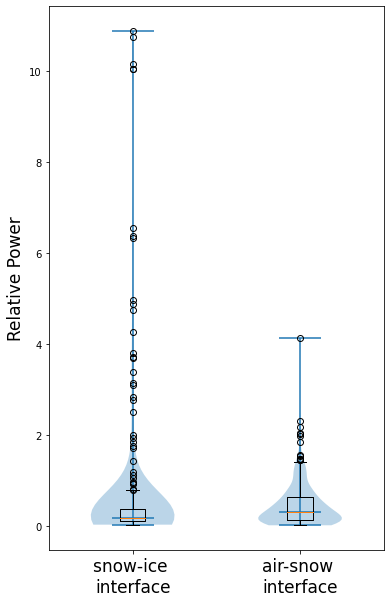

In [17]:
fig = plt.figure(figsize=(6,10))
plt.violinplot([closest_peak_amps_to_snowice_interp_range_bin, closest_peak_amps_to_airsnow_interp_range_bin], showmedians = True)
plt.boxplot([closest_peak_amps_to_snowice_interp_range_bin, closest_peak_amps_to_airsnow_interp_range_bin])
plt.xticks(ticks = np.arange(1,3,1), labels = ['snow-ice \ninterface','air-snow \ninterface'], fontsize = 17)
plt.ylabel("Relative Power",fontsize=17)
if saving:
    pass
    plt.savefig("../Thesis/graphics/InterfacePowersOfNearestPeaks"+str(icetype).upper()+".png",dpi=200)

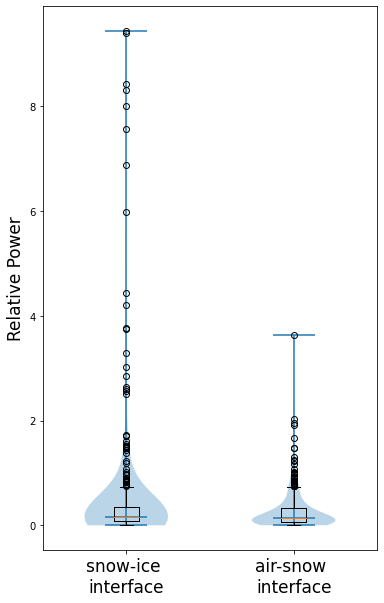

In [18]:
fig = plt.figure(figsize=(6,10))
plt.violinplot([snowice_interp_unlog_amps, airsnow_interp_unlog_amps], showmedians = True)
plt.boxplot([snowice_interp_unlog_amps, airsnow_interp_unlog_amps])
plt.xticks(ticks = np.arange(1,3,1), labels = ['snow-ice \ninterface','air-snow \ninterface'], fontsize = 17)
plt.ylabel("Relative Power",fontsize=17)
if saving:
    pass
    plt.savefig("../Thesis/graphics/InterfacePowersOfMeanAlts"+str(icetype).upper()+".png",dpi=200)


In [19]:
snowice_is_bigger_counter = 0
airsnow_is_bigger_counter = 0
ratios_of_snowice_to_airsnow_amps = np.array([],dtype='double')
decibel_differences_of_airsnow_and_snowice_amps = np.array([],dtype='double')
for i in range(len(snowice_interp_unlog_amps)):
    if snowice_interp_unlog_amps[i]>airsnow_interp_unlog_amps[i]:
        snowice_is_bigger_counter+=1
    elif airsnow_interp_unlog_amps[i]>snowice_interp_unlog_amps[i]:
        airsnow_is_bigger_counter+=1
    ratios_of_snowice_to_airsnow_amps = np.append(ratios_of_snowice_to_airsnow_amps, snowice_interp_unlog_amps[i]/airsnow_interp_unlog_amps[i])
decibel_differences_of_airsnow_and_snowice_log_amps = 10*np.log10(snowice_interp_unlog_amps) - 10*np.log10(airsnow_interp_unlog_amps)

In [20]:
print(np.mean(ratios_of_snowice_to_airsnow_amps))
print(len(ratios_of_snowice_to_airsnow_amps))
print(len(ratios_of_snowice_to_airsnow_amps[ratios_of_snowice_to_airsnow_amps<1])/len(ratios_of_snowice_to_airsnow_amps))


4.264464621818139
363
0.39669421487603307


In [21]:
print(np.mean(decibel_differences_of_airsnow_and_snowice_log_amps))

1.5496959102699506


In [22]:
# snowice_is_bigger_counter = 0
# airsnow_is_bigger_counter = 0
# ratios_of_snowice_to_airsnow_amps = np.array([],dtype='double')
# decibel_differences_of_airsnow_and_snowice_amps = np.array([],dtype='double')
# for i in range(len(closest_peak_amps_to_snowice_interp_range_bin)):
#     if closest_peak_amps_to_snowice_interp_range_bin[i]>closest_peak_amps_to_airsnow_interp_range_bin[i]:
#         snowice_is_bigger_counter+=1
#     elif closest_peak_amps_to_airsnow_interp_range_bin[i]>closest_peak_amps_to_snowice_interp_range_bin[i]:
#         airsnow_is_bigger_counter+=1
#     ratios_of_snowice_to_airsnow_amps = np.append(ratios_of_snowice_to_airsnow_amps, closest_peak_amps_to_snowice_interp_range_bin[i]/closest_peak_amps_to_airsnow_interp_range_bin[i])
# decibel_differences_of_airsnow_and_snowice_log_amps = 10*np.log10(closest_peak_amps_to_snowice_interp_range_bin) - 10*np.log10(closest_peak_amps_to_airsnow_interp_range_bin)

In [23]:
# print(np.mean(ratios_of_snowice_to_airsnow_amps))
# print(len(ratios_of_snowice_to_airsnow_amps[ratios_of_snowice_to_airsnow_amps<1])/len(ratios_of_snowice_to_airsnow_amps))

In [24]:
# print(np.mean(decibel_differences_of_airsnow_and_snowice_log_amps))